# Problem Statement
---
We have to perform **Time Series Analysis** on an airline passenger traffic dataset. It has the data on the number of passengers that have travelled with the airline on a particular route for the past few years. Using this data, we have to see if we can forecast the number of passengers for the next twelve months.

## Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Import Time Series Data: Airline Passenger Traffic Data

In [2]:
# Read the data:
data = pd.read_csv('airline-passenger-traffic+(1).csv', header=None)

# Name the columns:
data.columns = ['Month', 'Passenger']

# Update the format to date time:
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')

# Set Index the month column
data = data.set_index(data['Month'])
data = data.drop(columns='Month') # Removed extra Month column from the data
data.head()

,Passenger
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [3]:
# Check for the shape of the data
data.shape

(144, 1)

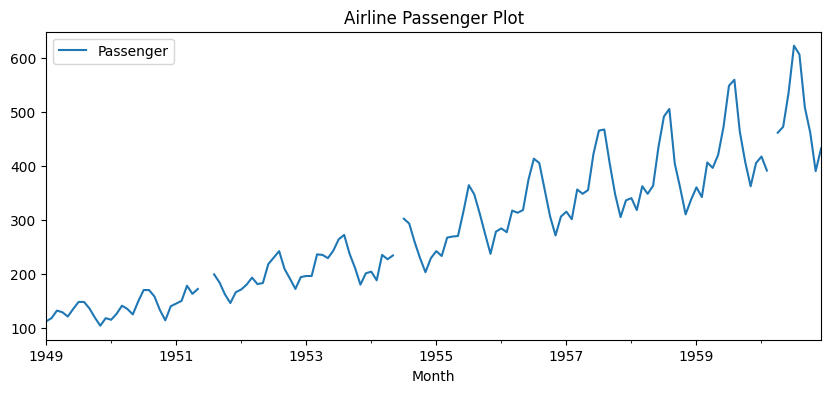

In [4]:
# Time series Analysis:
# Plot the Month wise distribution plot
data.plot(figsize=(10,4))
plt.title('Airline Passenger Plot')
plt.show()

- As we can observe there are some datas missing for few months lets analyze and fix it

## Handling Missing Value

In [5]:
# Check for the Missing datas in the dataset
data[data.isnull().any(axis=1)]

,Passenger
Month,
1951-06-01,NaN
1951-07-01,NaN
1954-06-01,NaN
1960-03-01,NaN


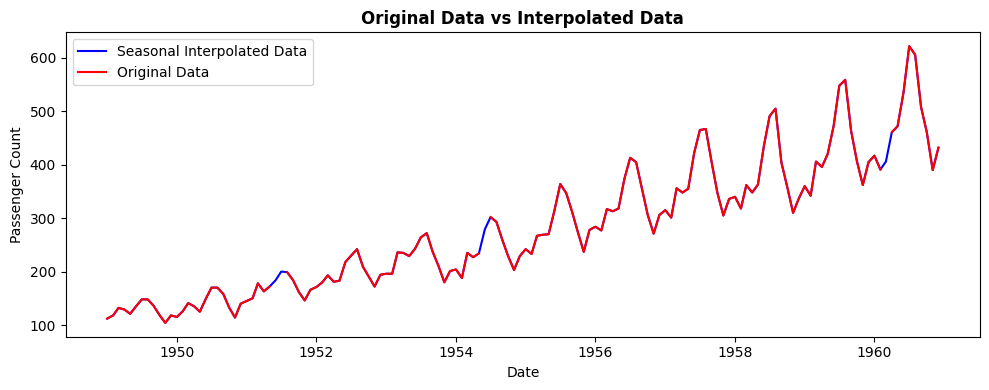

In [6]:
data_new = data.copy()

# Using Seasonal linear interpolation method to fill the data
data_new['Passenger'] = data_new.groupby(data_new.index.month)['Passenger'].transform(
    lambda x: x.interpolate(method='linear'))

# Plot the graph to see the difference between original data vs seasonally interpolated data
plt.figure(figsize=(10, 4))

# Plot interpolated data (blue)
plt.plot(data_new.index, data_new['Passenger'], label='Seasonal Interpolated Data', color='blue')

# Plot original data (red)
plt.plot(data.index, data['Passenger'], label='Original Data', color='red')

# Title and labels
plt.title('Original Data vs Interpolated Data', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Passenger Count')

# Add legend
plt.legend()

# Tight layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

## Treating Outliers

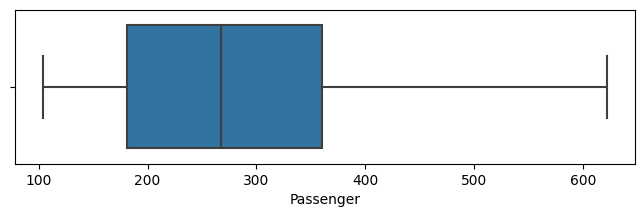

In [7]:
# First check for the outliers
plt.figure(figsize=(8, 2))
sns.boxplot(data=data_new, x='Passenger')
plt.show()

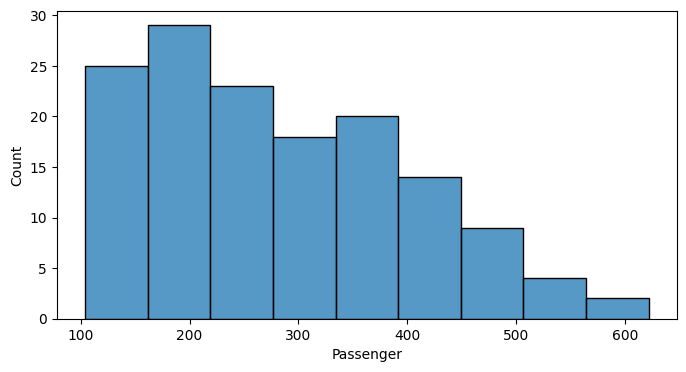

In [8]:
# According to the boxplot we don't have outliers
# Now let's check using Histogram
plt.figure(figsize=(8, 4))
sns.histplot(x=data_new['Passenger'])
plt.show()

## Time Series Decomposition
#### Additive and Multiplicative Decomposition

In [9]:
# Import liberaries for decomposition
import statsmodels.api as sm
from pylab import rcParams

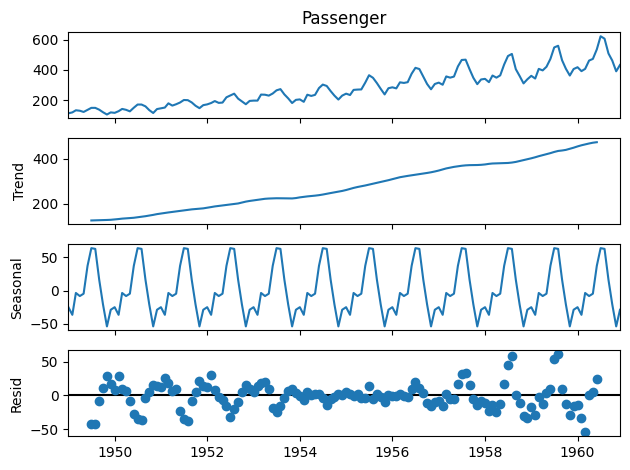

In [10]:
# Additive Decomposition
add_decomp = sm.tsa.seasonal_decompose(data_new['Passenger'], model='additive')
fig = add_decomp.plot()
plt.show()

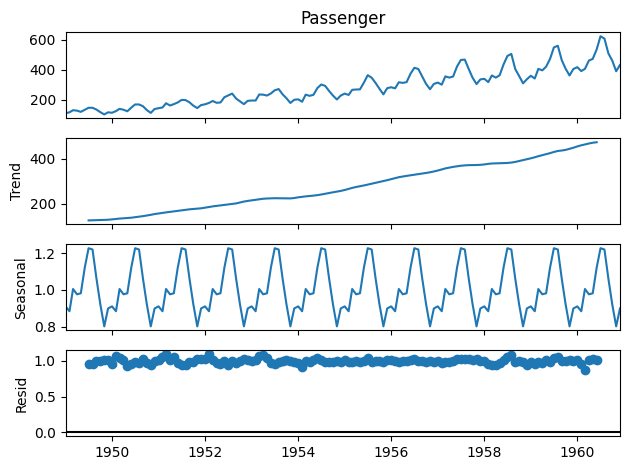

In [11]:
# Multiplicative Decomposition
mult_decomp = sm.tsa.seasonal_decompose(data_new['Passenger'], model='multiplicative')
fig = mult_decomp.plot()
plt.show()

# Build and evaluate Time Series Forecast
#### Split data into train and test set

In [12]:
train_len = 120
train = data_new[:train_len] # first 120 data for training
test = data_new[train_len:] # last 24 data for testing

### Naive Method

In [13]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passenger'][train_len-1]
y_hat_naive.head()

,Passenger,naive_forecast
Month,,
1959-01-01,360.0,337.0
1959-02-01,342.0,337.0
1959-03-01,406.0,337.0
1959-04-01,396.0,337.0
1959-05-01,420.0,337.0


#### Plot train test and forecast

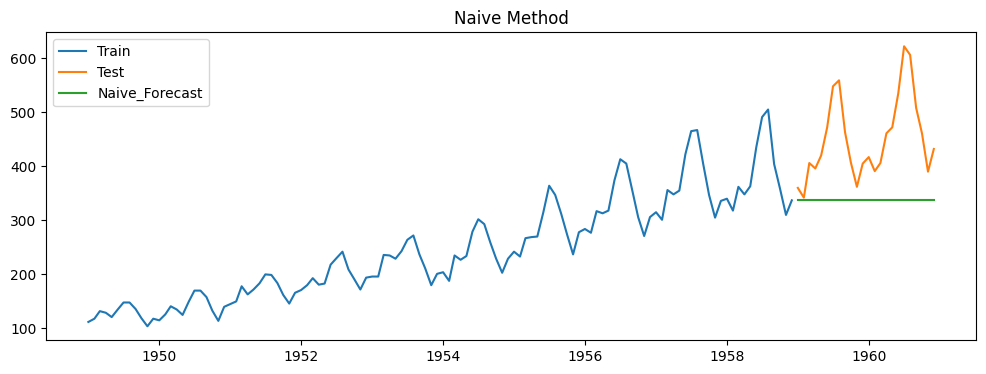

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(train.Passenger, label='Train')
plt.plot(test.Passenger, label='Test')
plt.plot(y_hat_naive.naive_forecast, label='Naive_Forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

#### Calculate RMSE and MAPE

In [15]:
n_rmse = np.sqrt(mean_squared_error(test.Passenger, y_hat_naive.naive_forecast)).round(2)
n_mape = np.round(np.mean(np.abs(((test.Passenger - y_hat_naive.naive_forecast)/test.Passenger)*100)), 2)

# Create a data frame to store these results'
result = pd.DataFrame({'Method':['Naive Method'], 'RMSE':[n_rmse], 'MAPE':[n_mape]})
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47


### Simple Average Method

In [16]:
y_hat_avg = test.copy()
y_hat_avg['AVG_Forecast'] = train.Passenger.mean()
y_hat_avg.head()

,Passenger,AVG_Forecast
Month,,
1959-01-01,360.0,246.0875
1959-02-01,342.0,246.0875
1959-03-01,406.0,246.0875
1959-04-01,396.0,246.0875
1959-05-01,420.0,246.0875


#### Plot train, test and forecast

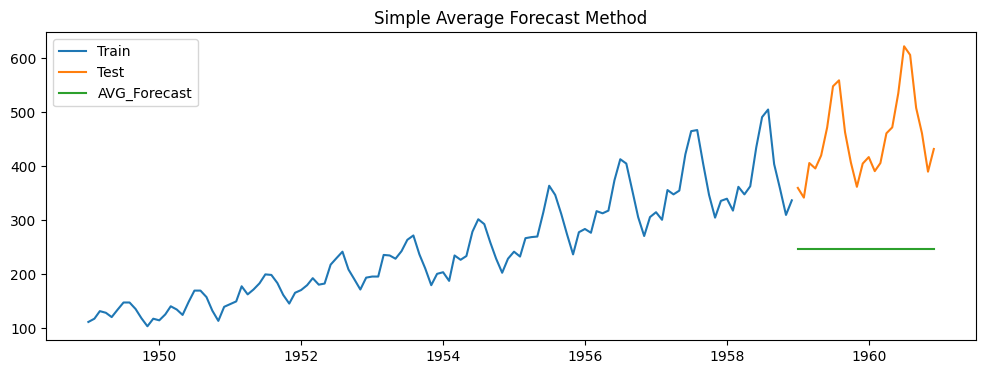

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(train.Passenger, label='Train')
plt.plot(test.Passenger, label='Test')
plt.plot(y_hat_avg.AVG_Forecast, label='AVG_Forecast')
plt.legend(loc='best')
plt.title('Simple Average Forecast Method')
plt.show()

#### Calculate RMSE and MAPE

In [18]:
s_rmse = np.sqrt(mean_squared_error(test.Passenger, y_hat_avg.AVG_Forecast)).round(2)
s_mape = np.round(np.mean(np.abs(((test.Passenger - y_hat_avg.AVG_Forecast)/test.Passenger)*100)), 2)

# Store value in DataFrame
temp_row = pd.DataFrame({'Method':['Simple Average Method'], 'RMSE':[s_rmse], 'MAPE':[s_mape]})
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12


In [19]:
y_hat_sma = test.copy()
ma_window = 12 # Define a window size
train_sma_val = train.Passenger.rolling(ma_window).mean() # Store moving average of train data
last_sma_val = train_sma_val.iloc[-1] # fetch the last MA
y_hat_sma['SMA_Forecast'] = last_sma_val
y_hat_sma.head()

,Passenger,SMA_Forecast
Month,,
1959-01-01,360.0,381.0
1959-02-01,342.0,381.0
1959-03-01,406.0,381.0
1959-04-01,396.0,381.0
1959-05-01,420.0,381.0


#### Plot train, test and SMA graph

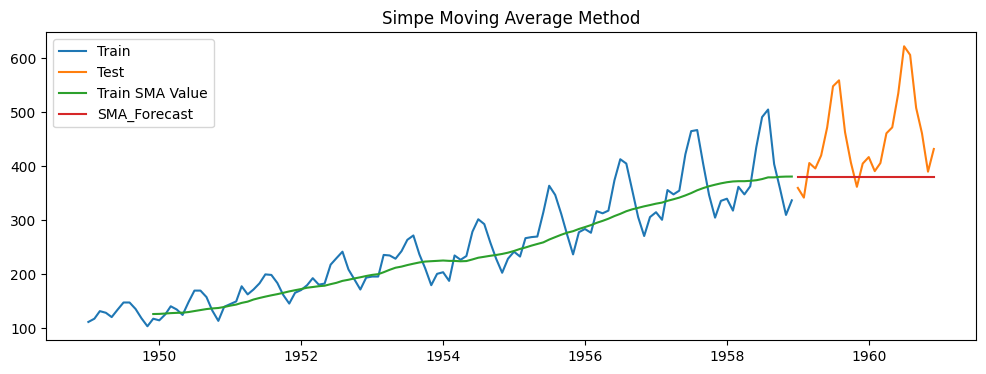

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(train.Passenger, label='Train')
plt.plot(test.Passenger, label='Test')
plt.plot(train_sma_val, label='Train SMA Value')
plt.plot(y_hat_sma.SMA_Forecast, label='SMA_Forecast')
plt.legend(loc='best')
plt.title('Simpe Moving Average Method')
plt.show()

#### Calculate RMSE and MAPE

In [21]:
ma_rmse = np.sqrt(mean_squared_error(test.Passenger, y_hat_sma.SMA_Forecast)).round(2)
ma_mape = np.round(np.mean(np.abs(((test.Passenger - y_hat_sma.SMA_Forecast)/test.Passenger)*100)), 2)

# Store value in DataFrame
temp_row = pd.DataFrame({'Method':['Simple Moving Average'], 'RMSE':[ma_rmse], 'MAPE':[ma_mape]})
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35


### Simple Exponential Smoothing Technique

In [22]:
model = sm.tsa.SimpleExpSmoothing(train.Passenger)
model_fit = model.fit(smoothing_level=0.2, optimized=False)
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['SES_Forecast'] = model_fit.forecast(24)
y_hat_ses.head()

{'smoothing_level': 0.2, 'smoothing_trend': None, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Passenger,SES_Forecast
Month,,
1959-01-01,360.0,374.89734
1959-02-01,342.0,374.89734
1959-03-01,406.0,374.89734
1959-04-01,396.0,374.89734
1959-05-01,420.0,374.89734


#### Plot train, test and forecast

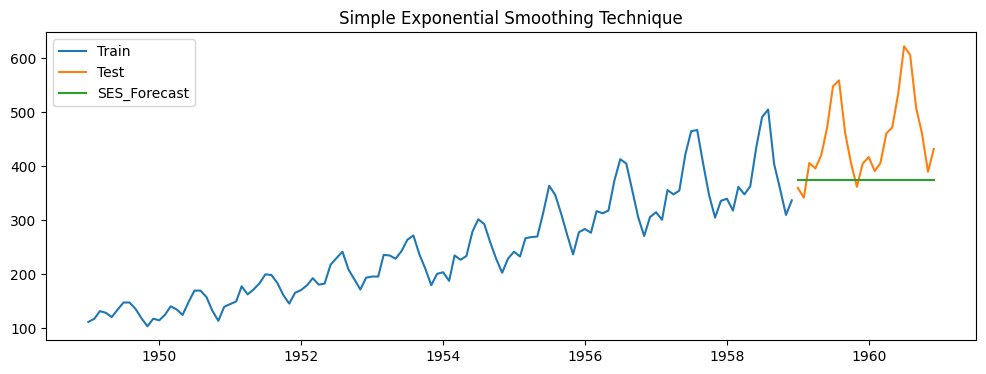

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(train.Passenger, label='Train')
plt.plot(test.Passenger, label='Test')
plt.plot(y_hat_ses.SES_Forecast, label='SES_Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Technique')
plt.show()

#### Calculate RMSE and MAPE

In [24]:
ses_rmse = np.sqrt(mean_squared_error(test.Passenger, y_hat_ses.SES_Forecast)).round(2)
ses_mape = np.round(np.mean(np.abs(((test.Passenger - y_hat_ses.SES_Forecast)/test.Passenger)*100)), 2)

# Store result in DataFrame
temp_row = pd.DataFrame({'Method':['Simple Exponential Smoothing Method'], 'RMSE':[ses_rmse], 'MAPE':[ses_mape]})
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31


### Holt's Method with trends

In [25]:
model = sm.tsa.ExponentialSmoothing(np.asarray(train['Passenger']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['Holt_Forecast'] = model_fit.forecast(len(test))
y_hat_holt.head()

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 118.46666666666661, 'initial_trend': 2.0606060606060677, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Passenger,Holt_Forecast
Month,,
1959-01-01,360.0,386.839737
1959-02-01,342.0,389.034324
1959-03-01,406.0,391.228912
1959-04-01,396.0,393.423499
1959-05-01,420.0,395.618086


#### Plot train, test and forecast

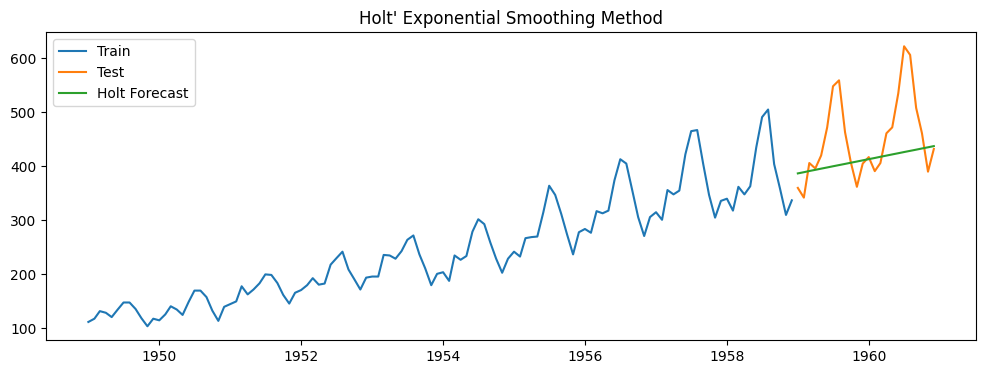

In [26]:
plt.figure(figsize=(12,4))
plt.plot(train.Passenger, label='Train')
plt.plot(test.Passenger, label='Test')
plt.plot(y_hat_holt.Holt_Forecast, label='Holt Forecast')
plt.legend(loc='best')
plt.title('Holt\' Exponential Smoothing Method')
plt.show()

#### Calculate MAPE and RMSE

In [27]:
h_rmse = np.sqrt(mean_squared_error(test.Passenger, y_hat_holt.Holt_Forecast)).round(2)
h_mape = np.round(np.mean(np.abs(((test.Passenger - y_hat_holt.Holt_Forecast)/test.Passenger)*100)), 2)

# Store data in DataFrame
temp_row = pd.DataFrame({'Method':['Holt\' Exponential Smoothing Method'], 'RMSE':[h_rmse], 'MAPE':[h_mape]})
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43


### Holt Winters' additive method with trend and seasonality

In [28]:
y_hat_hwa = test.copy()
model = sm.tsa.ExponentialSmoothing(np.asarray(train['Passenger']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['HW_forecast'] = model_fit.forecast(24)
y_hat_hwa.head()

{'smoothing_level': 0.23681952729052658, 'smoothing_trend': 0.0, 'smoothing_seasonal': 0.7631804727094734, 'damping_trend': nan, 'initial_level': 119.13830768727752, 'initial_trend': 2.27615482940308, 'initial_seasons': array([ -9.41418743,  -3.78505185,   8.84562071,   3.86668814,
        -4.74847893,   9.37474902,  21.39542689,  19.03590509,
         4.93423604, -13.92774369, -28.61617872, -12.45730658]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Passenger,HW_forecast
Month,,
1959-01-01,360.0,354.147965
1959-02-01,342.0,337.482110
1959-03-01,406.0,387.621354
1959-04-01,396.0,379.567081
1959-05-01,420.0,396.958948


#### Plot Train, test and forecast

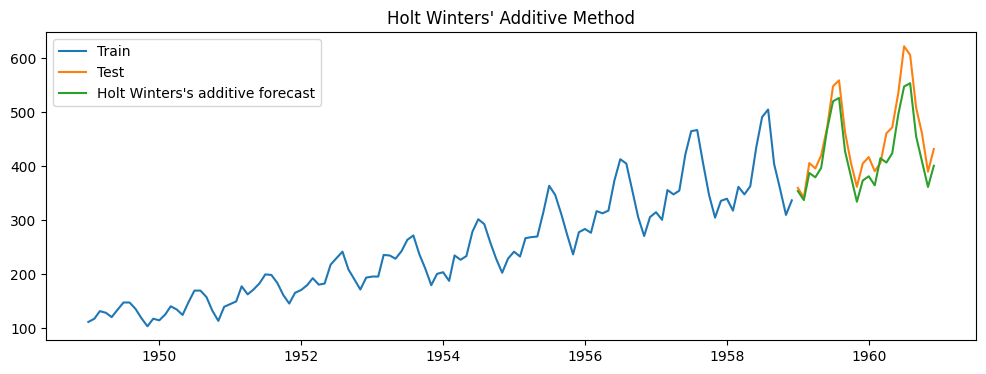

In [29]:
plt.figure(figsize=(12,4))
plt.plot(train.Passenger, label='Train')
plt.plot(test.Passenger, label='Test')
plt.plot(y_hat_hwa.HW_forecast, label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

#### Calculate RMSE and MAPE

In [30]:
hw_rmse = np.sqrt(mean_squared_error(test.Passenger, y_hat_hwa.HW_forecast)).round(2)
hw_mape = np.round(np.mean(np.abs(((test.Passenger - y_hat_hwa.HW_forecast)/test.Passenger)*100)), 2)

# Store data in DataFrame
temp_row = pd.DataFrame({'Method':['Holt Winters\' Additive Method'], 'RMSE':[hw_rmse], 'MAPE':[hw_mape]})
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43
5,Holt Winters' Additive Method,35.91,6.71


### Holt Winter's multiplicative method with trend and seasonality

In [31]:
y_hat_hwm = test.copy()
model = sm.tsa.ExponentialSmoothing(np.asarray(train.Passenger), seasonal_periods=12, trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['HWM_Forecast'] = model_fit.forecast(24)
y_hat_hwm.head()

{'smoothing_level': 0.3743611610496972, 'smoothing_trend': 3.969986689070455e-06, 'smoothing_seasonal': 0.6202785015940524, 'damping_trend': nan, 'initial_level': 113.0265008891472, 'initial_trend': 2.4479962961815955, 'initial_seasons': array([0.96956305, 1.02241732, 1.12621972, 1.07236076, 0.99261213,
       1.08544985, 1.17689322, 1.16082446, 1.0571857 , 0.91978536,
       0.81647272, 0.94350124]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Passenger,HWM_Forecast
Month,,
1959-01-01,360.0,350.815338
1959-02-01,342.0,333.590582
1959-03-01,406.0,387.893531
1959-04-01,396.0,380.390616
1959-05-01,420.0,398.247812


#### Plot train, test and forecast

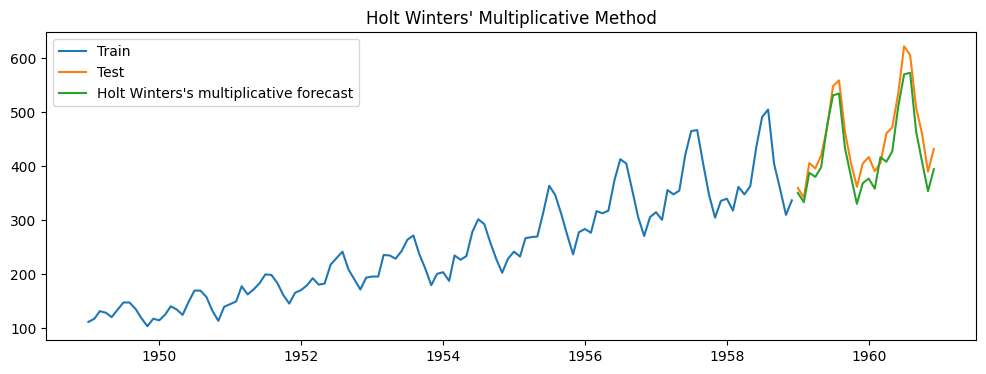

In [32]:
plt.figure(figsize=(12,4))
plt.plot(train.Passenger, label='Train')
plt.plot(test.Passenger, label='Test')
plt.plot(y_hat_hwm.HWM_Forecast, label='Holt Winters\'s multiplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Multiplicative Method')
plt.show()

#### Calculate RMSE and MAPE

In [33]:
hwm_rmse = np.sqrt(mean_squared_error(test.Passenger, y_hat_hwm.HWM_Forecast)).round(2)
hwm_mape = np.round(np.mean(np.abs(((test.Passenger - y_hat_hwm.HWM_Forecast)/test.Passenger)*100)), 2)

# Store data in DataFrame
temp_row = pd.DataFrame({'Method':['Holt Winters\' Multiplicative Method'], 'RMSE':[hwm_rmse], 'MAPE':[hwm_mape]})
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43
5,Holt Winters' Additive Method,35.91,6.71
6,Holt Winters' Multiplicative Method,32.36,6.44


## Auto Regressive Model
#### Stationary and Non-Stationary Time Series

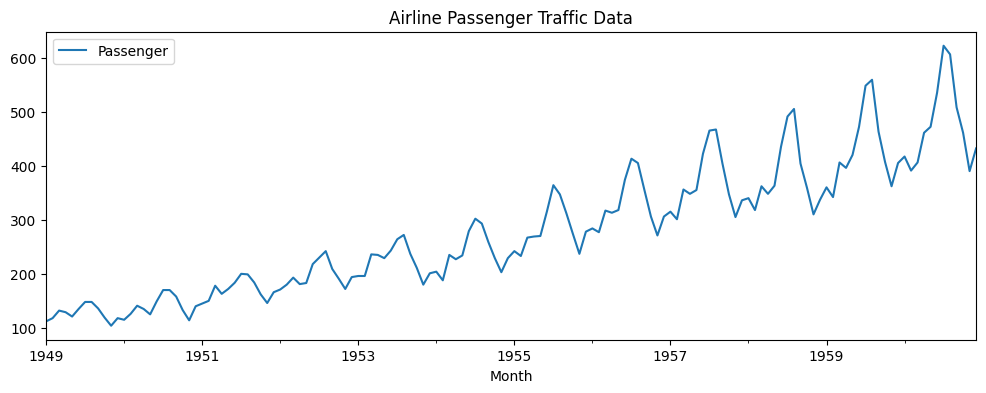

In [34]:
data_new.Passenger.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Data')
plt.show()

### Augmented Dickey-Fuller (ADF) test:

#### Null And Alternative Hypothesis:
1. **Null Hypothesis (H0):** The time series is non-stationary
2. **Alternative Hypothesis (H1):** The time series in stationary

**Observations to be done**
- If the p-value < significance level (e.g., 0.05), reject H₀: The series is stationary.
- If the p-value ≥ significance level, fail to reject H₀: The series is non-stationary.

In [35]:
adf_test = sm.tsa.adfuller(data_new.Passenger)
print('ADF Statistics:', adf_test[0]) # at 0 index it will provide Statistics
print('Critical Value @ 5%:', adf_test[4]['5%']) # at 4th index we will find critical value
print('P-Value: ', adf_test[1])

ADF Statistics: 0.969830349370903
Critical Value @ 5%: -2.8840418343195267
P-Value:  0.993937200600159


- Here p-value is greater than significance level, which means it **fails to Reject Null Hypothesis** it means **time series is non stationary**.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

#### Null And Alternative Hypothesis:
1. **Null Hypothesis (H0):** The time series is Stationary
2. **Alternative Hypothesis (H1):** The time series is non-stationary

**Observations to be done**
- If the p-value < significance level (e.g., 0.05), reject H₀: The series is non-stationary.
- If the p-value ≥ significance level, fail to reject H₀: The series is stationary.

In [36]:
kpss_test = sm.tsa.kpss(data_new.Passenger)
print('KPSS Statistics:', kpss_test[0]) # returns stats
print('Critical Value @ 5%:', kpss_test[3]['5%']) # returns critical value at 5%
print('P-Value:', kpss_test[1]) # Returns p-value

KPSS Statistics: 1.6522105915422938
Critical Value @ 5%: 0.463
P-Value: 0.01


C:\Users\diksh\AppData\Local\Temp\ipykernel_13920\1355380730.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = sm.tsa.kpss(data_new.Passenger)


- Here p-value is smaller than significance level, which means it **Reject Null Hypothesis** it means **time series is non stationary**.

### Box Cox Transformation

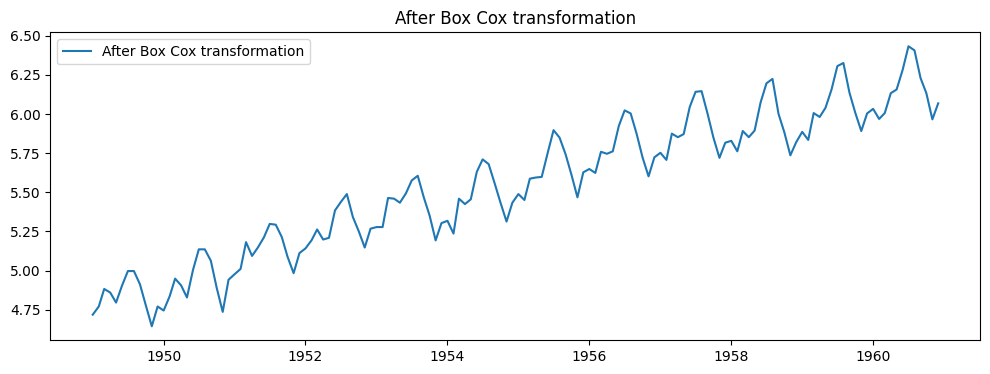

In [37]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data_new.Passenger, lmbda=0), index=data_new.index)

# plot transformed data
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox transformation')
plt.legend(loc='best')
plt.title('After Box Cox transformation')
plt.show()

- we can still see the trend in the graph so overcome it we have to use Differences

### Differencing

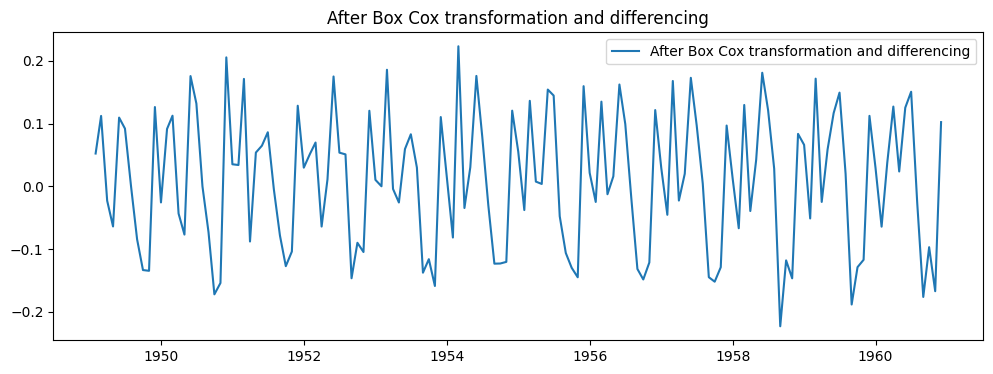

In [38]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index = data_new.index)
data_boxcox_diff.dropna(inplace=True) # it will drop first value from the data

# Plot Graph
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox transformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transformation and differencing')
plt.show()

**Now just check whether the time series is become stationary or not**

In [39]:
adf_test = sm.tsa.adfuller(data_boxcox_diff)
print('ADF Statistics:', adf_test[0]) # at 0 index it will provide Statistics
print('Critical Value @ 5%:', adf_test[4]['5%']) # at 4th index we will find critical value
print('P-Value: ', adf_test[1])

ADF Statistics: -3.2305768649040703
Critical Value @ 5%: -2.8840418343195267
P-Value:  0.018281604366471818


- According to the ADF it rejects the null hypothesis, now series is stationary.

In [40]:
kpss_test = sm.tsa.kpss(data_boxcox_diff)
print('KPSS Statistics:', kpss_test[0]) # returns stats
print('Critical Value @ 5%:', kpss_test[3]['5%']) # returns critical value at 5%
print('P-Value:', kpss_test[1]) # Returns p-value

KPSS Statistics: 0.03798440856444686
Critical Value @ 5%: 0.463
P-Value: 0.1


C:\Users\diksh\AppData\Local\Temp\ipykernel_13920\1596632299.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = sm.tsa.kpss(data_boxcox_diff)


- According to the KPSS it fails to rejects the null hypothesis, now series is stationary.

### Autocorrelation Function (ACF) plot

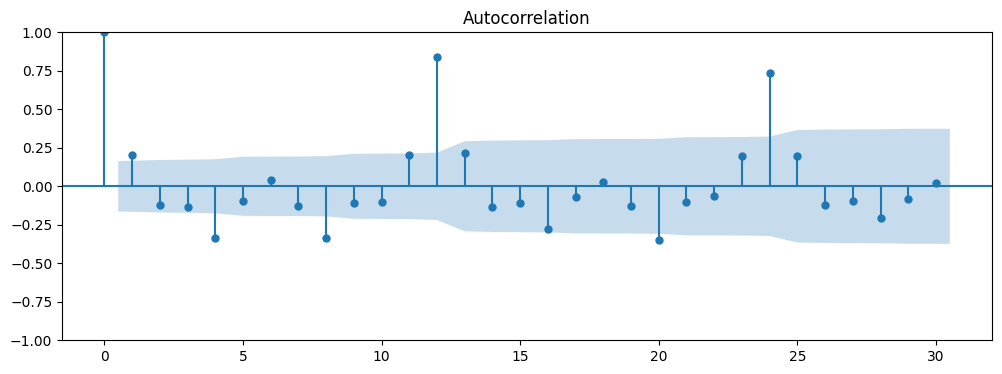

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

### Partial Autocorrelation Function (PACF) plot

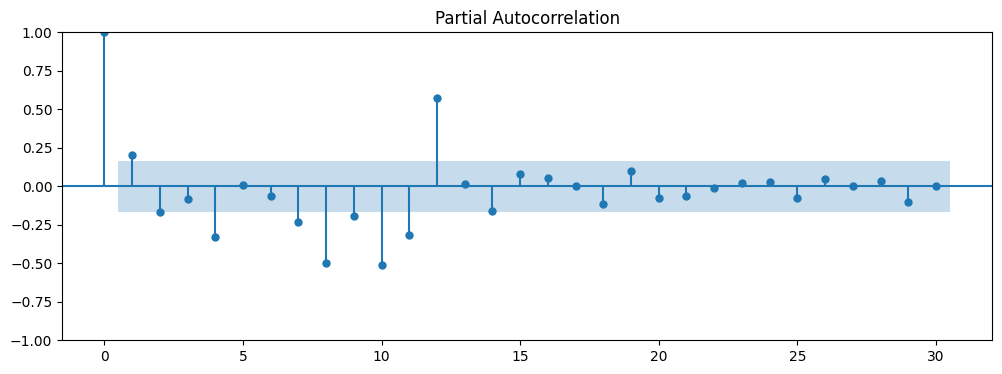

In [42]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

### Split train and test data

In [43]:
# Boxcox data split
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

# boxcox differences data split
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### Auto Regression (AR) Method:

In [44]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const     0.009477
ar.L1     0.185867
sigma2    0.010742
dtype: float64


C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Recover original time series

In [46]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum().reindex_like(data_boxcox_diff)
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

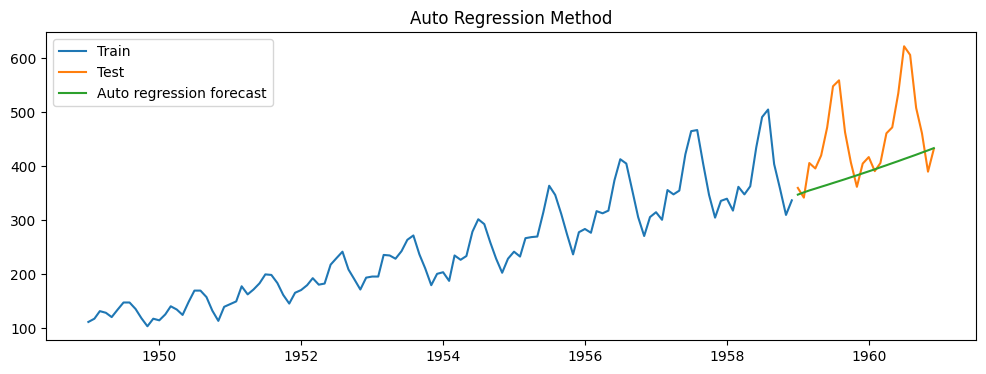

In [47]:
plt.figure(figsize=(12,4))
plt.plot(train['Passenger'], label='Train')
plt.plot(test['Passenger'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [48]:
rmse = np.sqrt(mean_squared_error(test['Passenger'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passenger']-y_hat_ar['ar_forecast'][test.index.min():])/test['Passenger'])*100,2)

temp_row = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43
5,Holt Winters' Additive Method,35.91,6.71
6,Holt Winters' Multiplicative Method,32.36,6.44
7,Autoregressive (AR) method,93.21,13.57


### Moving Average (MA) method

In [49]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const     0.009539
ma.L1     0.270931
sigma2    0.010571
dtype: float64


C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Recover original time series

In [50]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

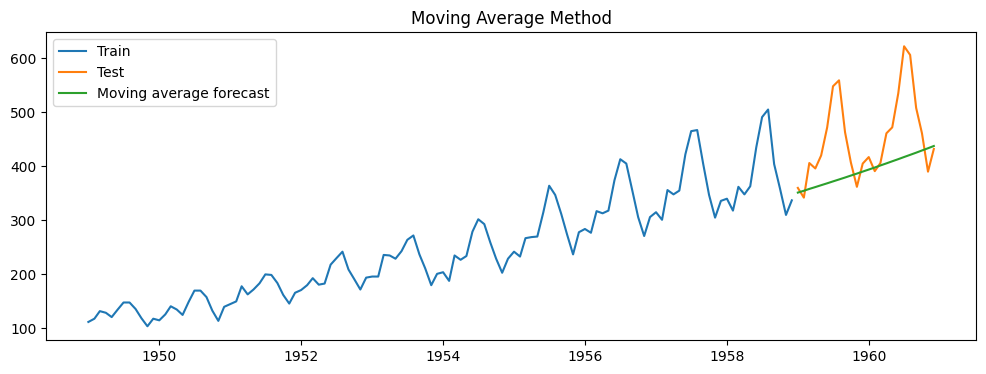

In [51]:
plt.figure(figsize=(12,4))
plt.plot(train['Passenger'], label='Train')
plt.plot(test['Passenger'], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [52]:
rmse = np.sqrt(mean_squared_error(test['Passenger'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passenger']-y_hat_ma['ma_forecast'][test.index.min():])/test['Passenger'])*100,2)

temp_row = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43
5,Holt Winters' Additive Method,35.91,6.71
6,Holt Winters' Multiplicative Method,32.36,6.44
7,Autoregressive (AR) method,93.21,13.57
8,Moving Average (MA) method,91.03,13.19


### Auto regression moving average method (ARMA)

In [53]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.009645
ar.L1    -0.537925
ma.L1     0.815783
sigma2    0.010060
dtype: float64


C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Recover original time series

In [54]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

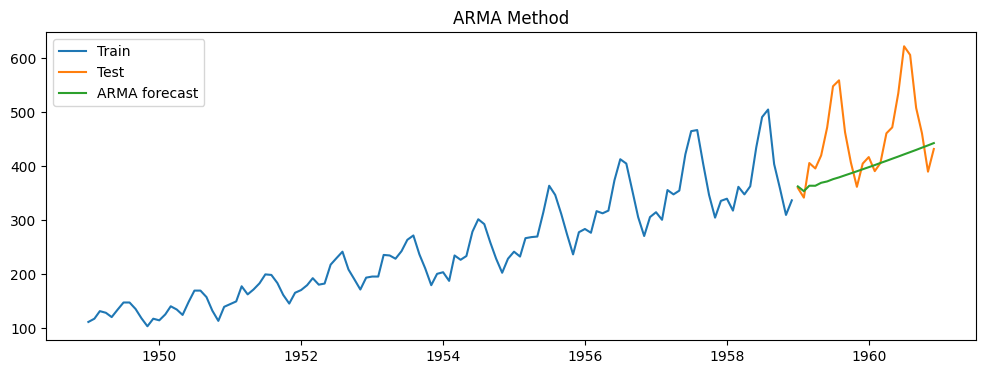

In [55]:
plt.figure(figsize=(12,4))
plt.plot( train['Passenger'], label='Train')
plt.plot(test['Passenger'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [56]:
rmse = np.sqrt(mean_squared_error(test['Passenger'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Passenger']-y_hat_arma['arma_forecast'][train_len-1:])/test['Passenger'])*100,2)

temp_row = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43
5,Holt Winters' Additive Method,35.91,6.71
6,Holt Winters' Multiplicative Method,32.36,6.44
7,Autoregressive (AR) method,93.21,13.57
8,Moving Average (MA) method,91.03,13.19
9,Autoregressive moving average (ARMA) method,88.18,12.61


### Seasonal auto regressive integrated moving average (SARIMA)

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ar.L1       0.380982
ma.L1      -0.670890
ar.S.L12   -0.089404
ma.S.L12   -0.499247
sigma2      0.001366
dtype: float64


### Recover original time series forecast

In [58]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

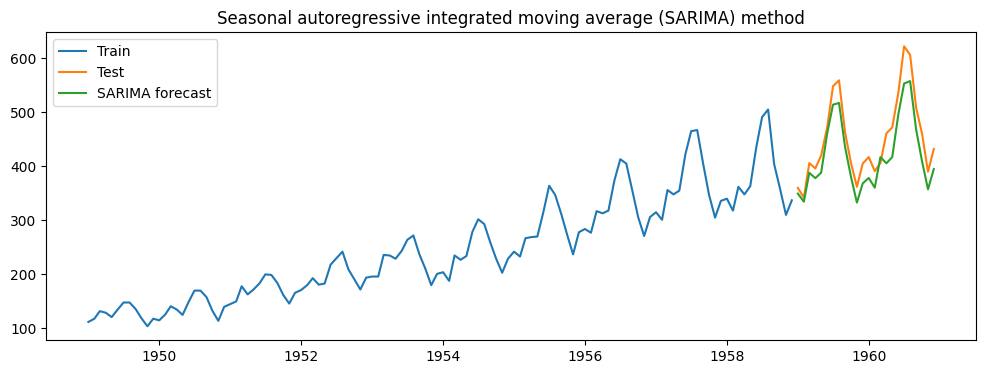

In [59]:
plt.figure(figsize=(12,4))
plt.plot(train['Passenger'], label='Train')
plt.plot(test['Passenger'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [60]:
rmse = np.sqrt(mean_squared_error(test['Passenger'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passenger']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Passenger'])*100,2)

temp_row = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43
5,Holt Winters' Additive Method,35.91,6.71
6,Holt Winters' Multiplicative Method,32.36,6.44
7,Autoregressive (AR) method,93.21,13.57
8,Moving Average (MA) method,91.03,13.19
9,Autoregressive moving average (ARMA) method,88.18,12.61


### Seasonal auto regressive integrate moving average with exogenous variable (SARIMAX)
#### Import promotion data

In [61]:
promo = pd.read_csv('promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


### Split promotion data into train and test data sets

In [62]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

### Build SARIMAX model

In [63]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train) 
model_fit = model.fit()
print(model_fit.params)

C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\diksh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Event       0.021175
ar.L1       0.428866
ma.L1      -0.706749
ar.S.L12   -0.090685
ma.S.L12   -0.528931
sigma2      0.001335
dtype: float64


### Recover original time series forecast

In [64]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(), exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

### Plot train, test and forecast

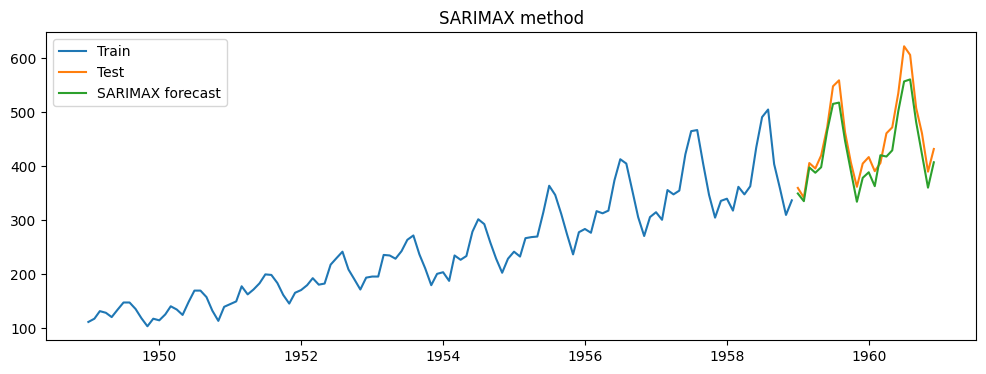

In [65]:
plt.figure(figsize=(12,4))
plt.plot(train['Passenger'], label='Train')
plt.plot(test['Passenger'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

### Calculate RMSE and MAPE

In [66]:
rmse = np.sqrt(mean_squared_error(test['Passenger'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passenger']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passenger'])*100,2)

temp_row = pd.DataFrame({'Method':['SARIMAX method'], 'RMSE': [rmse],'MAPE': [mape] })
result = pd.concat([result, temp_row], ignore_index=True)
result

,Method,RMSE,MAPE
0,Naive Method,137.03,23.47
1,Simple Average Method,218.86,44.12
2,Simple Moving Average,103.05,15.35
3,Simple Exponential Smoothing Method,107.33,16.31
4,Holt' Exponential Smoothing Method,80.94,11.43
5,Holt Winters' Additive Method,35.91,6.71
6,Holt Winters' Multiplicative Method,32.36,6.44
7,Autoregressive (AR) method,93.21,13.57
8,Moving Average (MA) method,91.03,13.19
9,Autoregressive moving average (ARMA) method,88.18,12.61
